In [1]:
import tensorflow as tf
import numpy as np
import mnist_data
import os
# import beta_vae as vae
import vae
import plot_utils
import glob
import random
import matplotlib.pyplot as plt
import cv2
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import random

配置参数

In [2]:
#gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#不平衡 类别
choose_c=3
#图像尺寸
IMAGE_SIZE_MNIST = 28
#隐变量维度
dim_z=2
#alpha classification loss balance
alpha=400
#隐层节点数
n_hidden=500
#学习率
learn_rate=1e-3
#训练轮数
n_epochs=50
#批量数目
batch_size=256
#标签样式 one-hot编码
one_hot=np.eye(10)
#结果保存路径
path=os.path.join(os.getcwd(),'result_refine')
if not os.path.exists(path):
    os.system('mkdir '+path)
RESULTS_DIR=path
#是否加入噪声，denoise vae
ADD_NOISE=False
dim_img = IMAGE_SIZE_MNIST**2
#beta-vae
beta=2.0

#画图
PRR=True
PRR_n_img_x=10
PRR_n_img_y=10
PRR_resize_factor=1.0
PMLR=True
PMLR_n_img_x=20
PMLR_n_img_y=20
PMLR_resize_factor=1.0
PMLR_z_range=2.0
PMLR_n_samples=5000

### 准备训练数据

In [3]:
train_total_data, train_size,_,_, test_data, test_labels = mnist_data.prepare_MNIST_data()


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### 改变数据集，获得类别不平衡数据集

In [4]:
ind=np.zeros(train_total_data.shape[0])
unbanlance_p=0.07
for p in range(train_total_data.shape[0]):
    ind[p]=np.argmax(train_total_data[p,-10:])
no_c_array=train_total_data[~np.equal(ind,choose_c)]
c_array=train_total_data[np.equal(ind,choose_c)]
origin_num_c=c_array.shape[0]
remain_num=int(c_array.shape[0]*unbanlance_p)
remain_c=c_array[:remain_num]
train_unbanlance_data=np.concatenate([no_c_array,remain_c],axis=0)
ub_train_size=train_unbanlance_data.shape[0]

#### check

unbanlance class: 3 ,original samples: 5099 ,unbanlance samples : 356 
unbanlance class: 3 , samples of dataset: 50000 ,now samples : 45257 
show sample of unbanlance class
one hot code: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


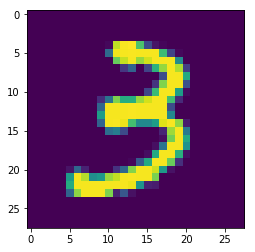

In [5]:
print('unbanlance class: %d ,original samples: %d ,unbanlance samples : %d '
      %(choose_c,origin_num_c,remain_num))
print('unbanlance class: %d , samples of dataset: %d ,now samples : %d '
      %(choose_c,train_size,ub_train_size))
print('show sample of unbanlance class')
index=random.choice(range(remain_num))
print('one hot code:',remain_c[index,-10:])
plt.imshow(remain_c[index,:-10].reshape([28,28]))

### 定义图结构

In [6]:
""" build graph """
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')
x_label = tf.placeholder(tf.float32, shape=[None, 10], name='img_label')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

#vae
y, z, cost, neg_marginal_likelihood, KL_divergence= vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)
z_tmp=tf.layers.Dense(10)(z)
z_class=tf.nn.softmax(z_tmp)
# print(z_cl)
classifation_loss=tf.reduce_mean(x_label * tf.log(z_class) + (1 - x_label) * tf.log(1 - z_class))
# network architecture beta vae
# y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob,beta)
loss=cost#-alpha*classifation_loss
# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)

decoded = vae.decoder(z_in, dim_img, n_hidden)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 在类别均衡数据集上训练VAE

epoch 0: L_tot 200.07 L_likelihood 192.79 L_divergence 7.27 classifation_loss -0.37 
epoch 1: L_tot 182.95 L_likelihood 176.33 L_divergence 6.62 classifation_loss -0.35 
epoch 2: L_tot 169.88 L_likelihood 163.20 L_divergence 6.68 classifation_loss -0.36 
epoch 3: L_tot 171.05 L_likelihood 164.28 L_divergence 6.77 classifation_loss -0.35 
epoch 4: L_tot 172.61 L_likelihood 166.37 L_divergence 6.24 classifation_loss -0.36 
epoch 5: L_tot 168.49 L_likelihood 162.41 L_divergence 6.09 classifation_loss -0.34 
epoch 6: L_tot 161.87 L_likelihood 155.84 L_divergence 6.03 classifation_loss -0.34 
epoch 7: L_tot 155.35 L_likelihood 149.24 L_divergence 6.12 classifation_loss -0.34 
epoch 8: L_tot 164.05 L_likelihood 158.30 L_divergence 5.75 classifation_loss -0.34 
epoch 9: L_tot 157.30 L_likelihood 151.25 L_divergence 6.05 classifation_loss -0.33 
epoch 10: L_tot 154.95 L_likelihood 149.07 L_divergence 5.89 classifation_loss -0.33 
epoch 11: L_tot 159.68 L_likelihood 153.70 L_divergence 5.99 cla

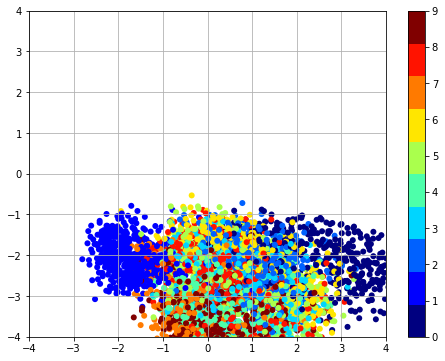

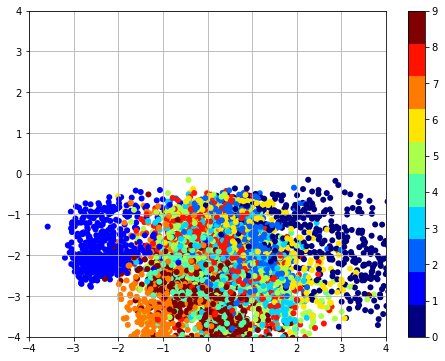

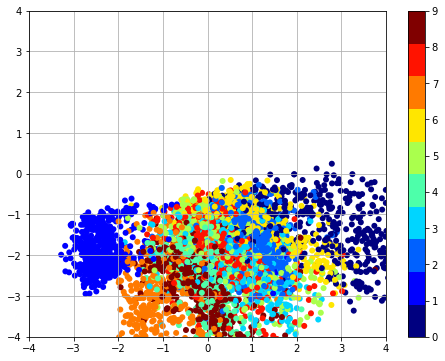

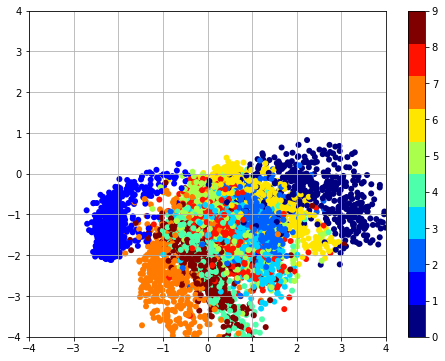

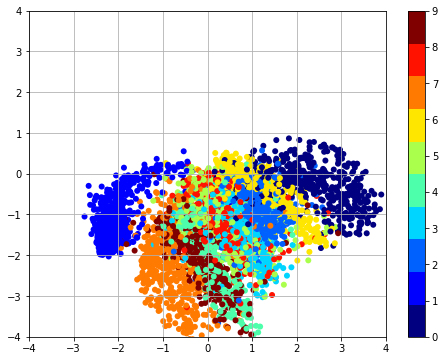

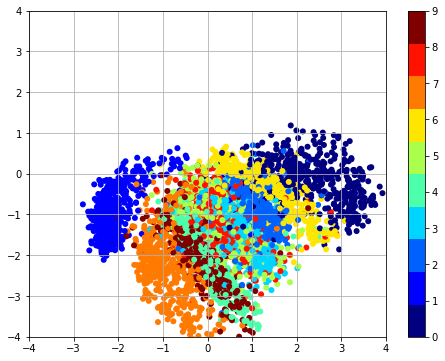

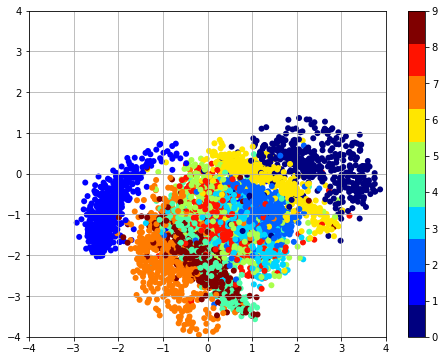

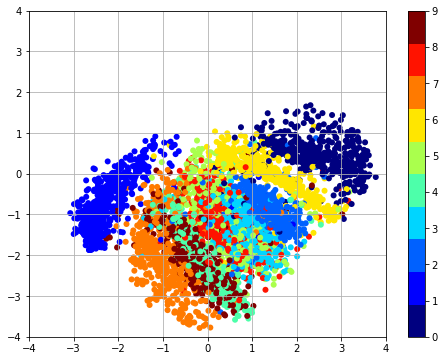

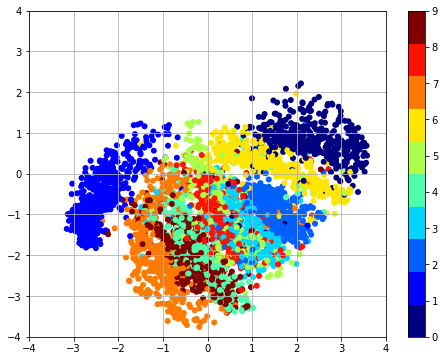

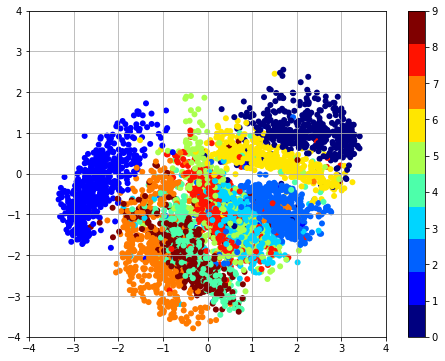

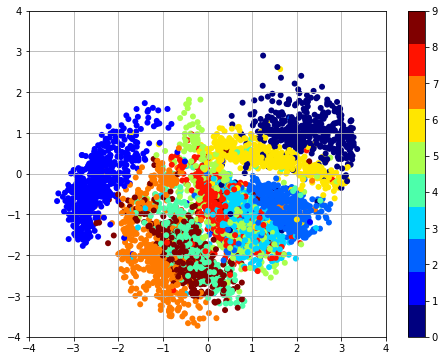

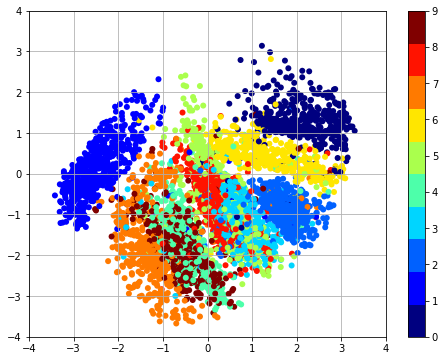

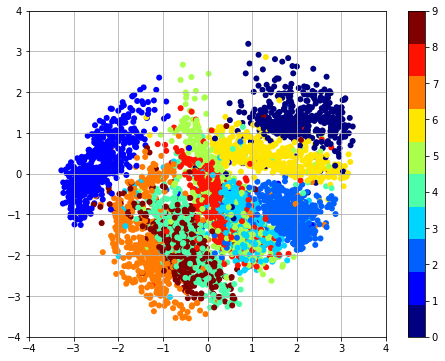

In [7]:
np.random.seed(100)
n_samples=train_size

""" training """

# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')
# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = vae.decoder(z_in, dim_img, n_hidden)

total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05  # 占用GPU90%的显存
sess = tf.Session(config=config)
# with tf.Session() as sess:

sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for epoch in range(n_epochs):

    # Random shuffling
    np.random.shuffle(train_total_data)
    train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS]
    train_label_= train_total_data[:, -mnist_data.NUM_LABELS:]
    
    # Loop over all batches
    for i in range(total_batch):
        # Compute the offset of the current minibatch in the data.
        offset = (i * batch_size) % (n_samples)
        batch_xs_input = train_data_[offset:(offset + batch_size), :]
        batch_xs_label = train_label_[offset:(offset + batch_size), :]
        batch_xs_target = batch_xs_input

        # add salt & pepper noise
        if ADD_NOISE:
            batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
            batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

        _, tot_loss, loss_likelihood, loss_divergence,class_loss= sess.run(
            (train_op, loss, neg_marginal_likelihood, KL_divergence,classifation_loss),
            feed_dict={x_hat: batch_xs_input, x: batch_xs_target, x_label:batch_xs_label,keep_prob : 0.9})

    # print cost every epoch
    print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f classifation_loss %03.2f " % (epoch, tot_loss, loss_likelihood, loss_divergence,class_loss))

    # if minimum loss is updated or final epoch, plot results
    if min_tot_loss > tot_loss or epoch+1 == n_epochs:
        min_tot_loss = tot_loss
        # Plot for reproduce performance
        if PRR:
            y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
            y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")
        # Plot for manifold learning result
        if PMLR and dim_z == 2:
            y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
            y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

            # plot distribution of labeled images
            z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
            PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")

target domain 980


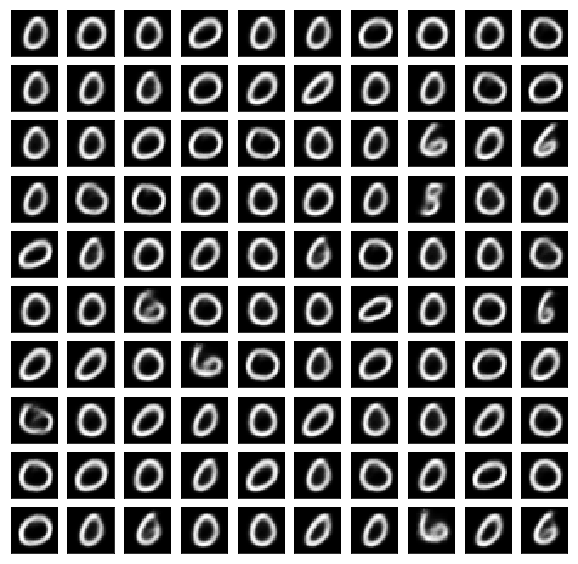

target domain 1135


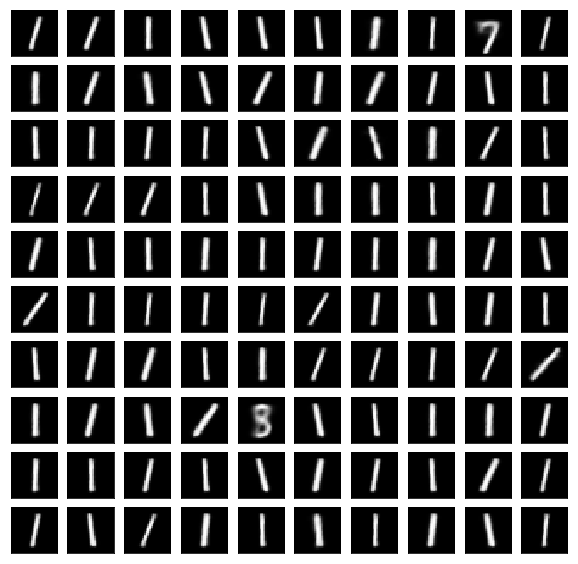

target domain 1032


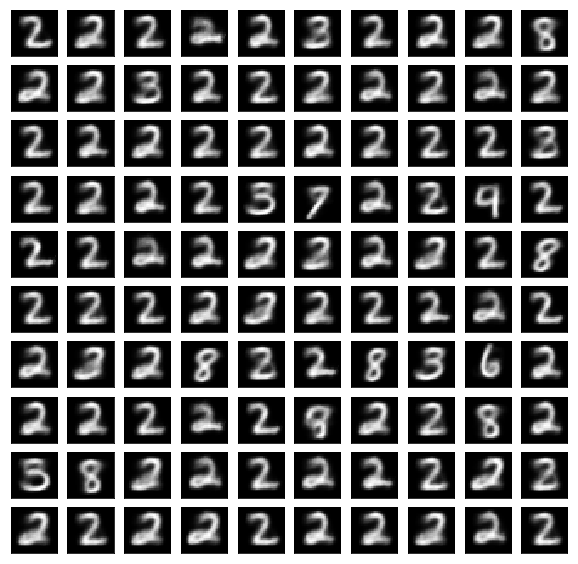

target domain 1010


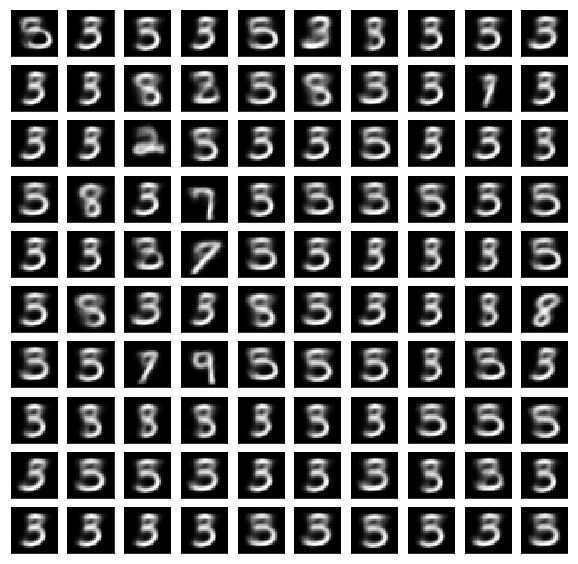

target domain 982


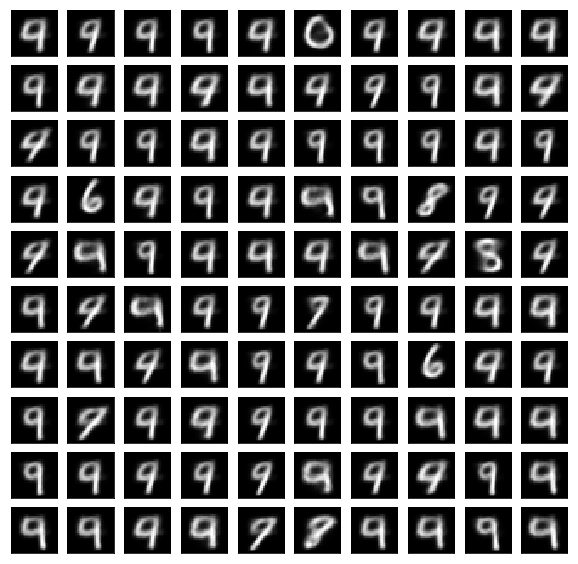

target domain 892


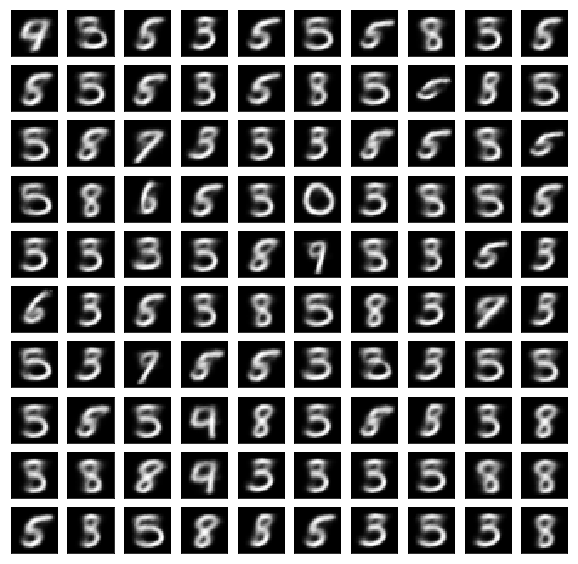

target domain 958


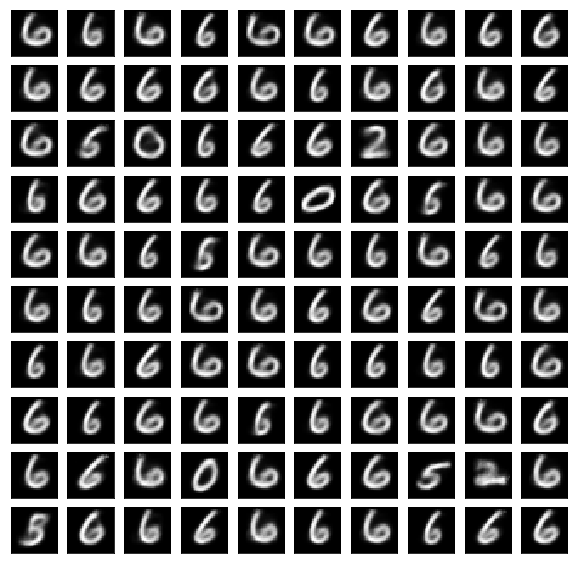

target domain 1028


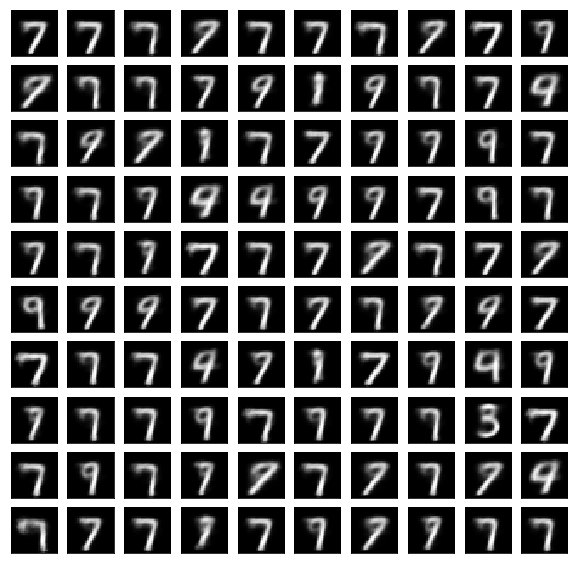

target domain 974


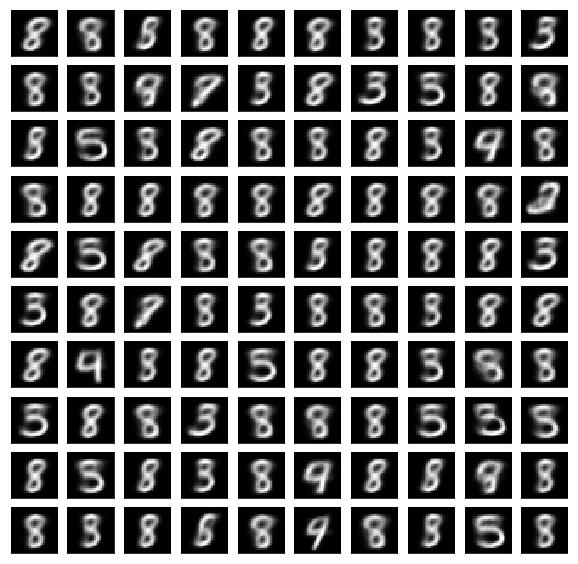

target domain 1009


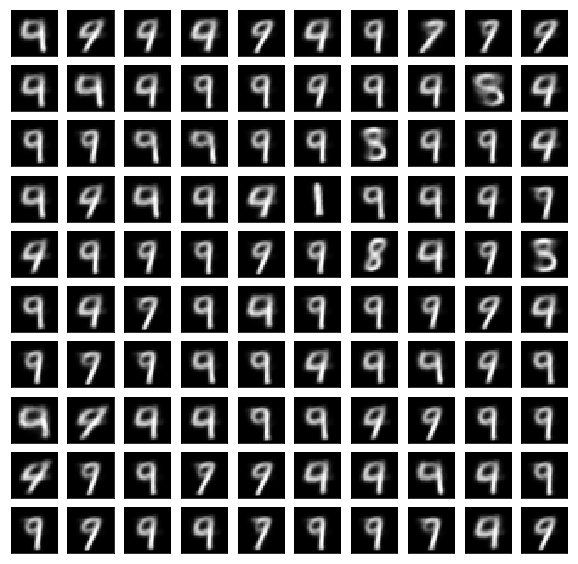

In [8]:
for choose_c in range(10):
    c=0
    for p in range(test_data.shape[0]):
        if np.argmax(test_labels[p])==choose_c:
            c+=1

    target_domain_size=c
    print('target domain',target_domain_size)

    k3=np.zeros([target_domain_size,784])
    c=0
    for p in range(test_data.shape[0]):
        if np.argmax(test_labels[p])==choose_c:
            k3[c]=test_data[p]
            c+=1

    c=0
    plt.figure(figsize=(10,10))
    for i in range(10):
        for j in range(10):
            x_PRR=k3[c].reshape([1,-1])
            y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
#             z_sample_=mu_ + sigma_ * np.random.normal(0.0,1.0,mu_.shape)
#             y_PMLR = sess.run(decoded, feed_dict={z_in: z_sample_.reshape([1,-1]), keep_prob : 1})
#             np.clip(y_PMLR,1e-8, 1 - 1e-8,out=y_PMLR)
#             loc=''.join([str(20),str(20),str(c+1)])
            plt.subplot(10,10,c+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(y_PRR.reshape([28,28]),cmap='gray')
            c+=1
    figpath=os.getcwd()+'/vae_ppt_'+str(n_epochs)+'_'+str(dim_z)
    if not os.path.exists(figpath):
        os.system('mkdir '+figpath)
    plt.savefig(figpath+'/'+str(choose_c)+'.jpg')
    plt.show()


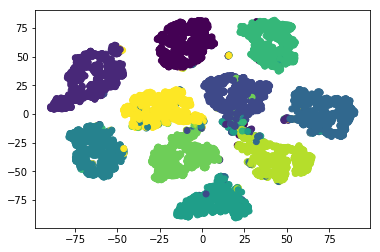

In [9]:
z_test = sess.run(z, feed_dict={x_hat: test_data, keep_prob : 1})
# z_sample_=mu_ + sigma_ * np.random.normal(0.0,1.0,mu_.shape)
from sklearn.manifold import TSNE
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
z_embedded = TSNE(n_components=2).fit_transform(z_test)
plt.scatter(z_embedded[:,0],z_embedded[:,1],c=10*np.argmax(test_labels,axis=1))

### 在类别不均衡数据集上训练VAE

In [7]:
np.random.seed(100)
n_samples=ub_train_size

""" training """

# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')

# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = vae.decoder(z_in, dim_img, n_hidden)
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05  # 占用GPU90%的显存
sess = tf.Session(config=config)
# with tf.Session() as sess:

sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for epoch in range(n_epochs):

    # Random shuffling
    np.random.shuffle(train_unbanlance_data)
    train_data_ = train_unbanlance_data[:, :-mnist_data.NUM_LABELS]
    train_label_= train_unbanlance_data[:, -mnist_data.NUM_LABELS:]
    
    # Loop over all batches
    for i in range(total_batch):
        # Compute the offset of the current minibatch in the data.
        offset = (i * batch_size) % (n_samples)
        batch_xs_input = train_data_[offset:(offset + batch_size), :]
        batch_xs_label = train_label_[offset:(offset + batch_size), :]
        batch_xs_target = batch_xs_input

        # add salt & pepper noise
        if ADD_NOISE:
            batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
            batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

        _, tot_loss, loss_likelihood, loss_divergence,class_loss= sess.run(
            (train_op, loss, neg_marginal_likelihood, KL_divergence,classifation_loss),
            feed_dict={x_hat: batch_xs_input, x: batch_xs_target, x_label:batch_xs_label,keep_prob : 0.9})

    # print cost every epoch
    print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f classifation_loss %03.2f " % (epoch, tot_loss, loss_likelihood, loss_divergence,class_loss))

    # if minimum loss is updated or final epoch, plot results
    if min_tot_loss > tot_loss or epoch+1 == n_epochs:
        min_tot_loss = tot_loss
        # Plot for reproduce performance
        if PRR:
            y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
            y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")

        # Plot for manifold learning result
        if PMLR and dim_z == 2:
            y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
            y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
            PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

            # plot distribution of labeled images
            z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
            PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")


epoch 0: L_tot 265.08 L_likelihood 183.61 L_divergence 19.43 classifation_loss -0.16 
epoch 1: L_tot 227.97 L_likelihood 160.94 L_divergence 20.62 classifation_loss -0.12 
epoch 2: L_tot 215.46 L_likelihood 157.14 L_divergence 20.22 classifation_loss -0.10 
epoch 3: L_tot 197.30 L_likelihood 147.65 L_divergence 18.95 classifation_loss -0.08 
epoch 4: L_tot 193.25 L_likelihood 145.39 L_divergence 17.08 classifation_loss -0.08 
epoch 5: L_tot 187.87 L_likelihood 145.66 L_divergence 16.81 classifation_loss -0.06 
epoch 6: L_tot 185.39 L_likelihood 148.33 L_divergence 15.63 classifation_loss -0.05 
epoch 7: L_tot 178.49 L_likelihood 143.33 L_divergence 15.72 classifation_loss -0.05 
epoch 8: L_tot 167.66 L_likelihood 135.73 L_divergence 15.62 classifation_loss -0.04 
epoch 9: L_tot 173.98 L_likelihood 140.93 L_divergence 14.36 classifation_loss -0.05 
epoch 10: L_tot 167.29 L_likelihood 136.63 L_divergence 14.96 classifation_loss -0.04 
epoch 11: L_tot 162.75 L_likelihood 133.26 L_divergen

### 获得不平衡类别隐空间的均值和方差

In [8]:
#设置batch size
ub_batch_size=2
target_batch = int(remain_num / ub_batch_size)

#同一类别的隐变量
vec_ari_a=np.zeros([target_batch*ub_batch_size,dim_z])
for offset in range(target_batch):
    x_batch=remain_c[:,:-10][offset*ub_batch_size:(offset+1)*ub_batch_size]
    z_batch = sess.run(z, feed_dict={x_hat: x_batch, keep_prob : 1})
    vec_ari_a[offset*ub_batch_size:(offset+1)*ub_batch_size]=z_batch
mu_,sigma_=vec_ari_a.mean(axis=0),vec_ari_a.std(axis=0)


#### check

In [9]:
print('samples of participate in compute vector arithmetic:{} '.format(target_batch*ub_batch_size))
print('mu:{},sigma:{}'.format(mu_,sigma_))
print('max value:{},min value:{}'.format(np.max(vec_ari_a,axis=0),np.min(vec_ari_a,axis=0)))

samples of participate in compute vector arithmetic:562 
mu:[0.66983513 0.2305172  0.08337113],sigma:[0.36866828 0.25986884 0.29233129]
max value:[2.32028317 1.52025759 1.6400497 ],min value:[-1.5921998  -1.55284202 -0.91103178]


### 可视化在隐空间采样得到的图片

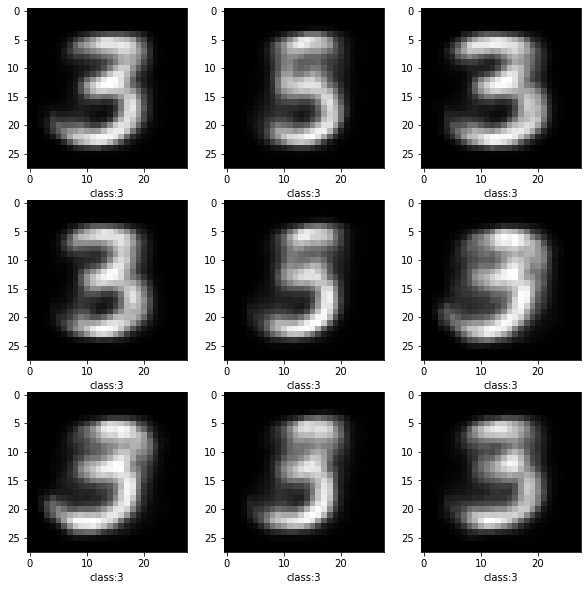

In [10]:
c=0
plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(3):
        z_sample_=mu_ + sigma_ * np.random.normal(0.0,1.0,mu_.shape)
        y_PMLR = sess.run(decoded, feed_dict={z_in: z_sample_.reshape([1,-1]), keep_prob : 1})
        label = sess.run(z_class, feed_dict={z: z_sample_.reshape([1,-1]), keep_prob : 1})
        np.clip(y_PMLR,1e-8, 1 - 1e-8,out=y_PMLR)
        loc=''.join([str(3),str(3),str(c+1)])
        plt.subplot(eval(loc))
        plt.xlabel('class:{}'.format(np.argmax(label)))
        plt.imshow(y_PMLR.reshape([28,28]),cmap='gray')
        c+=1
# figpath=os.getcwd()+'/'+str(n_epochs)+'_'+str(dim_z)
# if not os.path.exists(figpath):
#     os.system('mkdir '+figpath)
plt.show()

### 测试隐空间分类器

In [11]:
test_batch_size=2
test_batch=int(test_data.shape[0]/test_batch_size)
c=0
for offset in range(test_batch):
    x_batch=test_data[offset*test_batch_size:(offset+1)*test_batch_size]
    label_batch=test_labels[offset*test_batch_size:(offset+1)*test_batch_size]
    label = sess.run(z_class, feed_dict={x_hat: x_batch,keep_prob : 1})
    c+=np.sum(np.argmax(label,axis=1)==np.argmax(label_batch,axis=1))
print(c/test_batch/test_batch_size)

0.9575


### 使用VAE形成类别平衡的数据集

In [12]:
train_rebanlance_data=np.zeros([train_size,794])
train_rebanlance_dis_label=np.zeros([train_size,794])
k=train_unbanlance_data.shape[0]
train_rebanlance_data[:k]=train_unbanlance_data[:]
train_rebanlance_dis_label[:k]=train_unbanlance_data[:]
while k<train_size:
    z_sample=mu_ + sigma_ * np.random.normal(0.0,1.0,mu_.shape)
    y_reconstruct = sess.run(decoded,feed_dict={z_in: z_sample.reshape([1,-1]), keep_prob : 1})
    np.clip(y_reconstruct,1e-8, 1 - 1e-8,out=y_reconstruct)
    y_label = sess.run(z_class,feed_dict={x_hat: y_reconstruct.reshape([1,-1]), keep_prob : 1})
    if np.argmax(y_label)!=choose_c:
        continue
    tmp1=np.concatenate([y_reconstruct,y_label],axis=1)
    label_sample=one_hot[choose_c].reshape([1,-1])
    tmp2=np.concatenate([y_reconstruct,label_sample],axis=1)
    train_rebanlance_data[k]=tmp1
    train_rebanlance_dis_label[k]=tmp2
    k+=1

# rb_train_size=train_rebanlance_data.shape[0]

#### check

show sample of rebanlance dataset


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


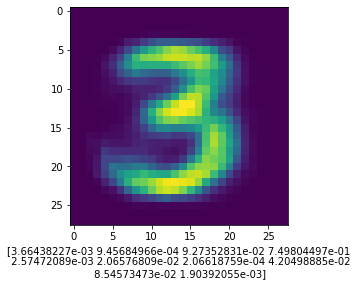

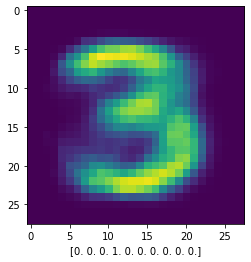

In [13]:
print('show sample of rebanlance dataset')
index=random.choice(range(train_unbanlance_data.shape[0],train_size))
plt.xlabel(train_rebanlance_data[index,-10:])
plt.imshow(train_rebanlance_data[index,:-10].reshape([28,28]))
plt.show()
index=random.choice(range(train_unbanlance_data.shape[0],train_size))
plt.xlabel(train_rebanlance_dis_label[index,-10:])
plt.imshow(train_rebanlance_dis_label[index,:-10].reshape([28,28]))

In [14]:
np.save('./train_rebanlance_data.npy',train_rebanlance_data)

In [15]:
np.save('./train_rebanlance_dis_label.npy',train_rebanlance_dis_label)

In [16]:
np.save('./train_unbanlance_data.npy',train_unbanlance_data)

### 使用缩放,剪切等数据增强技术形成类别平衡的数据集

In [17]:
#rotation_range : 旋转的角度
zoom_size= int(IMAGE_SIZE_MNIST*1.2)
# width_shift_range : 水平移动占图像宽度的比例
# height_shift_range 
# from scipy import misc, ndimage
# import random
c_array_inhance=np.zeros([origin_num_c,794])
c_array_inhance[:remain_num]=c_array[:]
x_process1=tf.image.resize(tf.image.central_crop(x_hat,0.8),[zoom_size,zoom_size])
# x_process2=tf.image.resize(tf.image.random_crop(x_hat,0.8),[zoom_size,zoom_size])
# x_sample=tf.placeholder(tf.float32,shape=[28,28])
for k in range(remain_num,origin_num_c):
    ind=random.choice(range(remain_num))

    x_process=tf.image.central_crop(tf.image.resize())

    transform=[]
    y_label,y_reconstruct = sess.run((z_class,decoded) ,feed_dict={z_in: z_sample.reshape([1,-1]), keep_prob : 1})
    np.clip(y_reconstruct,1e-8, 1 - 1e-8,out=y_reconstruct)
    c_array_inhance[k]=np.concatenate([y_reconstruct,y_label],axis=1)
train_rebanlance_data=np.concatenate([no_c_array,c_array_inhance],axis=0)
rb_train_size=train_rebanlance_data.shape[0]

ValueError: could not broadcast input array from shape (5638,794) into shape (563,794)

In [ ]:
plt.imshow(p)